# Colab Training Pipeline

This notebook sets up the full anomaly detection framework, downloads the selected dataset from the TS-AD repo, and launches training. Execute each cell in order on Google Colab. Adjust paths and configuration as needed.


In [1]:
%pip install -q torch numpy pandas scikit-learn pyyaml requests tqdm matplotlib seaborn


## 1. Environment Setup

Define project paths and pull the SMD files from the OmniAnomaly repository’s `ServerMachineDataset` folder. (These are the canonical splits used in many papers.)


In [2]:
import shutil
import zipfile
from pathlib import Path
from urllib.request import urlretrieve

DATASET_NAME = "smd"  # SMD is stored under ServerMachineDataset in OmniAnomaly
DATA_ROOT = Path("data/raw")
DATA_ROOT.mkdir(parents=True, exist_ok=True)
SMD_DIR = DATA_ROOT / "SMD"

if (SMD_DIR / "train").exists():
    print("SMD dataset already prepared.")
else:
    repo_zip = DATA_ROOT / "OmniAnomaly.zip"
    repo_tmp = DATA_ROOT / "OmniAnomaly_tmp"
    repo_url = "https://github.com/NetManAIOps/OmniAnomaly/archive/refs/heads/master.zip"
    print("Downloading OmniAnomaly repository...")
    urlretrieve(repo_url, repo_zip)
    with zipfile.ZipFile(repo_zip, "r") as zf:
        zf.extractall(repo_tmp)
    extracted_root = next(repo_tmp.glob("OmniAnomaly*/ServerMachineDataset"))
    shutil.copytree(extracted_root, SMD_DIR, dirs_exist_ok=True)
    shutil.rmtree(repo_tmp)
    repo_zip.unlink(missing_ok=True)
    print("SMD dataset extracted to", SMD_DIR)



SMD dataset extracted to data/raw/SMD


## 2. Mount Google Drive (IMPORTANT: Do this before training!)

Mount Drive so training outputs are automatically saved. If training gets interrupted, you can resume from the last checkpoint saved to Drive.


In [5]:
from google.colab import drive
drive.mount('/content/drive')
print("✓ Drive mounted. Training outputs will auto-save to Drive/MyDrive/DMProject_backup/outputs/")


Mounted at /content/drive
✓ Drive mounted. Training outputs will auto-save to Drive/MyDrive/DMProject_backup/outputs/


In [4]:
!unzip DMProject.zip -d /content/

Archive:  DMProject.zip
   creating: /content/DMProject/
   creating: /content/DMProject/.git/
  inflating: /content/DMProject/.git/AUTO_MERGE  
  inflating: /content/DMProject/.git/COMMIT_EDITMSG  
  inflating: /content/DMProject/.git/config  
  inflating: /content/DMProject/.git/description  
  inflating: /content/DMProject/.git/FETCH_HEAD  
  inflating: /content/DMProject/.git/HEAD  
   creating: /content/DMProject/.git/hooks/
  inflating: /content/DMProject/.git/hooks/applypatch-msg.sample  
  inflating: /content/DMProject/.git/hooks/commit-msg.sample  
  inflating: /content/DMProject/.git/hooks/fsmonitor-watchman.sample  
  inflating: /content/DMProject/.git/hooks/post-update.sample  
  inflating: /content/DMProject/.git/hooks/pre-applypatch.sample  
  inflating: /content/DMProject/.git/hooks/pre-commit.sample  
  inflating: /content/DMProject/.git/hooks/pre-merge-commit.sample  
  inflating: /content/DMProject/.git/hooks/pre-push.sample  
  inflating: /content/DMProject/.git/hook

## 3. Launch Training

Update any hyperparameters in `configs/default.yaml`, then run the training script. Results, checkpoints, and score arrays will appear in `outputs/` and be automatically backed up to Drive every 5 epochs.


In [13]:
%cd /content/DMProject

%cd /content
!rm -rf DMProject/data
!mv data DMProject/data

/content/DMProject


In [16]:
!python -m src.training.run --config configs/default.yaml --data_root data/raw --output_dir outputs


Training: 100% 14/14 [00:02<00:00,  6.25it/s]
Evaluating: 100% 14/14 [00:00<00:00, 48.90it/s]
Epoch 1 | Recon 0.8258 | Mask 0.5390
✓ Saved to Drive: DMProject_backup/outputs/history.json
Training: 100% 14/14 [00:01<00:00,  7.06it/s]
Evaluating: 100% 14/14 [00:00<00:00, 52.04it/s]
Epoch 2 | Recon 0.5210 | Mask 0.3339
✓ Saved to Drive: DMProject_backup/outputs/history.json
Training: 100% 14/14 [00:01<00:00,  8.00it/s]
Evaluating: 100% 14/14 [00:00<00:00, 64.87it/s]
Epoch 3 | Recon 0.4315 | Mask 0.2778
✓ Saved to Drive: DMProject_backup/outputs/history.json
Training: 100% 14/14 [00:01<00:00,  8.52it/s]
Evaluating: 100% 14/14 [00:00<00:00, 63.84it/s]
Epoch 4 | Recon 0.3946 | Mask 0.2551
✓ Saved to Drive: DMProject_backup/outputs/history.json
Training: 100% 14/14 [00:01<00:00,  8.36it/s]
Evaluating: 100% 14/14 [00:00<00:00, 64.36it/s]
Epoch 5 | Recon 0.3691 | Mask 0.2424
✓ Saved to Drive: DMProject_backup/outputs/history.json
✓ Saved to Drive: DMProject_backup/outputs/checkpoint_epoch_5.pt


## 4. Evaluate & Visualize

Run the evaluation helper to compute metrics and generate anomaly score plots.


In [17]:
%cd /content/DMProject
from pathlib import Path

# If outputs are only in Drive, copy them back
if not Path("outputs/scores.npy").exists() and Path("/content/drive/MyDrive/DMProject_backup/outputs/scores.npy").exists():
    print("Copying outputs from Drive...")
    !cp -r /content/drive/MyDrive/DMProject_backup/outputs /content/DMProject/outputs

# Run evaluation with PYTHONPATH set to project root
!PYTHONPATH=/content/DMProject python scripts/evaluate.py --scores outputs/scores.npy --labels outputs/labels.npy --output outputs/eval --percentile 95


/content/DMProject
Saved metrics and plot to outputs/eval


In [19]:
%cd /content/DMProject
!zip -r outputs.zip outputs

/content/DMProject
  adding: outputs/ (stored 0%)
  adding: outputs/checkpoint_epoch_25.pt (deflated 9%)
  adding: outputs/history.json (deflated 81%)
  adding: outputs/checkpoint_epoch_2.pt (deflated 9%)
  adding: outputs/scores.npy (deflated 8%)
  adding: outputs/checkpoint_epoch_40.pt (deflated 9%)
  adding: outputs/checkpoint_epoch_70.pt (deflated 9%)
  adding: outputs/checkpoint_epoch_50.pt (deflated 9%)
  adding: outputs/eval/ (stored 0%)
  adding: outputs/eval/roc.png (deflated 11%)
  adding: outputs/eval/precision_recall.png (deflated 11%)
  adding: outputs/eval/scores.png (deflated 15%)
  adding: outputs/eval/score_distribution.png (deflated 16%)
  adding: outputs/eval/metrics.json (deflated 39%)
  adding: outputs/checkpoint_epoch_55.pt (deflated 9%)
  adding: outputs/labels.npy (deflated 97%)
  adding: outputs/checkpoint_epoch_60.pt (deflated 9%)
  adding: outputs/checkpoint_epoch_85.pt (deflated 9%)
  adding: outputs/checkpoint_epoch_30.pt (deflated 9%)
  adding: outputs/che

In [23]:
%cd /content/DMProject
!python scripts/plot_losses.py

/content/DMProject
Saved loss plot to outputs/losses.png


**Evaluation and Outputs**

,threshold,precision,recall,f1,anomaly_ratio,predicted_anomaly_ratio,roc_auc,pr_auc
0,66.080826,0.911111,0.356522,0.5125,0.129797,0.05079,0.950567,0.758364


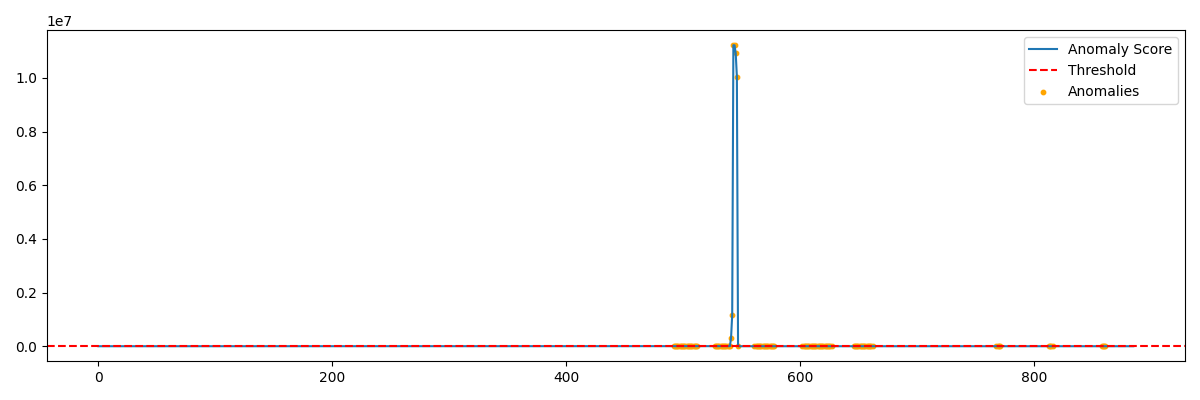

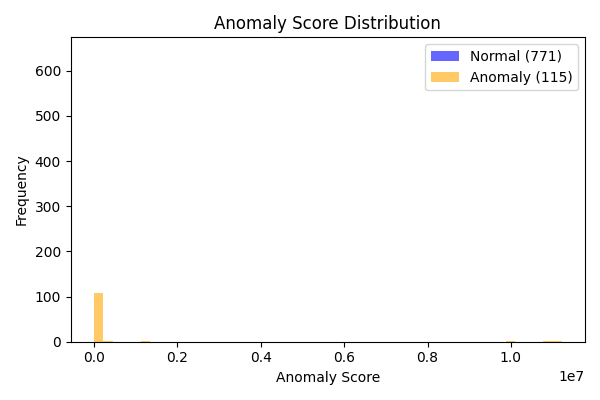

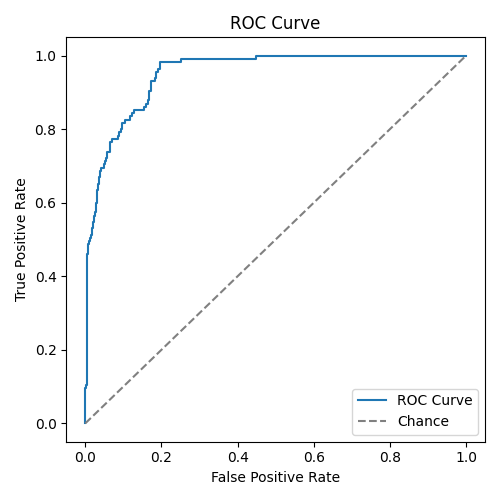

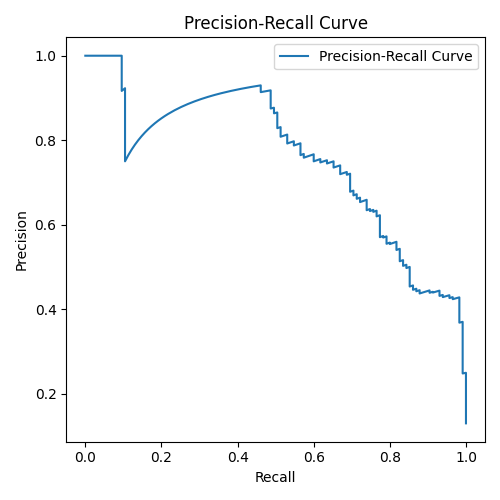

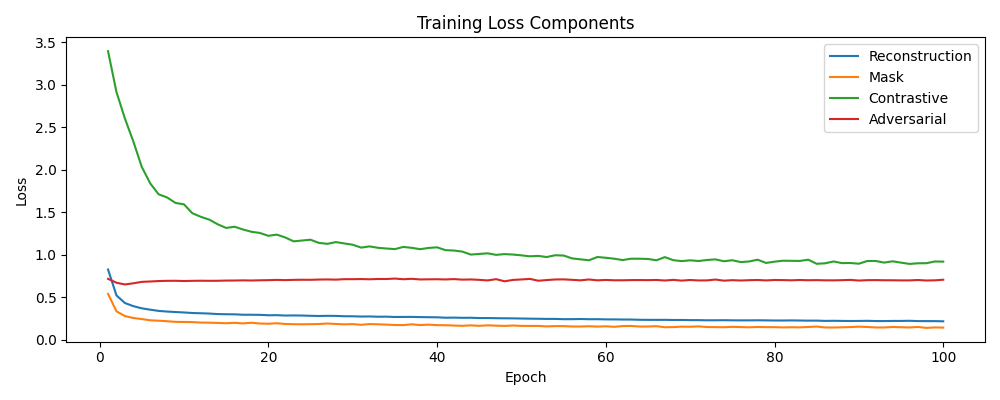

In [26]:
from pathlib import Path
import json
import pandas as pd
from IPython.display import display, Image, HTML

eval_dir = Path("outputs/eval")
loss_path = Path("outputs/losses.png")

# Load metrics
with open(eval_dir / "metrics.json", "r", encoding="utf-8") as f:
    metrics = json.load(f)

display(HTML("<h3>Evaluation Metrics</h3>"))
display(pd.DataFrame([metrics]))

def show_image(title: str, path: Path) -> None:
    if path.exists():
        display(HTML(f"<h4>{title}</h4>"))
        display(Image(filename=str(path)))
    else:
        display(HTML(f"<h4>{title}</h4><p><em>Not found: {path}</em></p>"))

show_image("Anomaly Scores", eval_dir / "scores.png")
show_image("Score Distribution", eval_dir / "score_distribution.png")
show_image("ROC Curve", eval_dir / "roc.png")
show_image("Precision-Recall Curve", eval_dir / "precision_recall.png")
show_image("Training Losses", loss_path)